In [103]:
import matplotlib.pyplot as plt
import numpy as np
import keyboard as kb
import networkx as nx
import time as t
from IPython.display import clear_output

In [104]:
class pawn:
    def __init__(self, x=0, y=0):
        self.x, self.y=x, y
        self.history=[]
    def __repr__(self):
        return "["+str(self.x)+", "+str(self.y)+"]"
    def move(self, direction):
        origin=[self.x, self.y]
        if direction=="left":
            if self.x > 0:
                self.x-=1
        elif direction=="right":
            if self.x < 8:
                self.x+=1
        elif direction=="up":
            if self.y > 0:
                self.y-=1
        elif direction=="down":
            if self.y < 8:
                self.y+=1
        elif direction=="doubleleft":
            if self.x > 1:
                self.x-=2
        elif direction=="doubleright":
            if self.x < 7:
                self.x+=2
        elif direction=="doubleup":
            if self.y > 1:
                self.y-=2
        elif direction=="doubledown":
            if self.y < 7:
                self.y+=2
        destination=[self.x, self.y]
        movement=[origin, destination]
        if movement not in self.history:
            self.history.append(movement)
    def future_move(self, direction):
        x, y=self.x, self.y
        fx, fy=x, y
        if direction=="left": fx-=1
        elif direction=="right": fx+=1
        elif direction=="up": fy-=1
        elif direction=="down": fy+=1
        elif direction=="doubleleft": fx-=2
        elif direction=="doubleright": fx+=2
        elif direction=="doubleup": fy-=2
        elif direction=="doubledown": fy+2
        return [[x, y], [fx, fy]]

    def coord(self):
        return [self.x, self.y]
    
    def near_coord(self):
        x, y=self.x, self.y
        return [[x-1, y], [x, y-1], [x+1, y], [x, y+1]]

In [105]:
class wall:
    def __init__(self, x=0, y=0, direction="left"):
        self.x, self.y, self.direction=x, y, direction
    def __repr__(self):
        return "["+str(self.x)+", "+str(self.y)+", " + self.direction + "]"

In [106]:
class pawnController:
    def __init__(self):
        self.pawnList={}
    def add_pawn(self, name, pawn):
        if name not in self.pawnList:
            if 0 <= pawn.x <= 8 and 0 <= pawn.y <= 8: 
                self.pawnList[name]=pawn

    def matrix(self):
        matrix=[[0 for _ in range(9)] for _ in range(9)]
        for i in self.pawnList:
            pawn=self.pawnList[i]
            matrix[pawn.y][pawn.x]=1
        return matrix

    def move_pawn(self, name, direction):
        self.pawnList[name].move(direction)

    def detect_near(self, name):
        near_pos=self.pawnList[name].near_coord()
        for i in self.pawnList:
            pawn=self.pawnList[i]
            coord=pawn.coord()
            if coord==near_pos[0]:      return "left"
            elif coord==near_pos[1]:    return "up"
            elif coord==near_pos[2]:    return "right"
            elif coord==near_pos[3]:    return "down"
        return 0
    
    def can_move_to(self, name, ill_moves):
        pawn=self.pawnList[name]
        pos_moves=["down", "left", "right", "up"]
        if self.detect_near(name):
            near=self.detect_near(name)
            pos_moves[pos_moves.index(near)]="double"+pos_moves[pos_moves.index(near)]
        to_remove=[]
        for i in pos_moves:
            fut_move=pawn.future_move(i)
            if fut_move in ill_moves:
                to_remove.append(i)
        for i in to_remove:
            pos_moves.remove(i)
        return pos_moves


In [107]:
class wallController:
    def __init__(self):
        self.wallList={}
    def add_wall(self, name, wall):
        if name not in self.wallList:
            if wall.direction == "left" and 2 <= wall.x <= 9 and 1 <= wall.y <= 8:
                self.wallList[name]=wall
            elif wall.direction == "up" and 1 <= wall.x <= 8 and 2 <= wall.y <= 9:
                self.wallList[name]=wall
    def matrix(self):
        matrix=[[0 for _ in range(10)] for _ in range(10)]
        for i in self.wallList:
            wall=self.wallList[i]
            if wall.direction == "left":
                matrix[wall.y][wall.x-1]+=2
                matrix[wall.y][wall.x]+=2
            elif wall.direction == "up":
                matrix[wall.y][wall.x]+=3
                matrix[wall.y-1][wall.x]+=3
        return matrix

    def ill_moves(self, i_type):
        #i_type=full, wall
        illegal_moves=[]
        if i_type=="full":
            for i in range(9):
                illegal_moves.append([[0, i], [-1, i]])
                illegal_moves.append([[1, i], [-1, i]])
                illegal_moves.append([[8, i], [9, i]])
                illegal_moves.append([[7, i], [9, i]])
                illegal_moves.append([[i, 0], [i, -1]])
                illegal_moves.append([[i, 1], [i, -1]])
                illegal_moves.append([[i, 8], [i, 9]])
                illegal_moves.append([[i, 7], [i, 9]])
        for i in self.wallList:
            wall=self.wallList[i]
            x=wall.x
            y=wall.y
            if wall.direction=="left":
                illegal_moves.extend([[[x-1, y], [x-1, y-1]],
                                        [[x-1, y-1], [x-1, y]],
                                        [[x-2, y], [x-2, y-1]],
                                        [[x-2, y-1], [x-2, y]],
                                        [[x-2, y-2], [x-2, y]],
                                        [[x-1, y-2], [x-1, y]],
                                        [[x-2, y+1], [x-2, y-1]],
                                        [[x-1, y+1], [x-1, y-1]],
                                        [[x-2, y-1], [x-1, y]],
                                        [[x-1, y], [x-2, y-1]],
                                        [[x-2, y], [x-1, y-1]],
                                        [[x-1, y-1], [x-2, y]]])
            elif wall.direction=="up":
                illegal_moves.extend([[[x, y-2], [x-1, y-2]],
                                        [[x-1, y-2], [x, y-2]],
                                        [[x, y-1], [x-1, y-1]],
                                        [[x-1, y-1], [x, y-1]],
                                        [[x-2, y-2], [x, y-2]],
                                        [[x-2, y-1], [x, y-1]],
                                        [[x+1, y-2], [x-1, y-2]],
                                        [[x+1, y-1], [x-1, y-1]],
                                        [[x-1, y-2], [x, y-1]],
                                        [[x, y-1], [x-1, y-2]],
                                        [[x-1, y-1], [x, y-2]],
                                        [[x, y-2], [x-1, y-1]]])
        return illegal_moves

In [108]:
class board:
    def __init__(self):
        self.pawnController=pawnController()
        self.wallController=wallController()
    def get_pawn(self, name):
        return self.pawnController.pawnList[name]
    def add_pawn(self, name, pawn):
        self.pawnController.add_pawn(name, pawn)
    def move_pawn(self, name, direction):
        pawn=self.pawnController.pawnList[name]
        ill_moves=self.wallController.ill_moves("full")
        if self.pawnController.detect_near(name)==direction:
            direction="double"+direction
        if pawn.future_move(direction) in ill_moves:
            return 0
        else:
            if pawn.future_move(direction) not in pawn.history:
                repeating_move=False
            else: repeating_move=True
            self.pawnController.move_pawn(name, direction)
        if not repeating_move:
            return 1
        else:
            return 2
    def add_wall(self, name, wall):
        self.wallController.add_wall(name, wall)
    def get_wall(self):
        return self.wallController.wallList
    def ill_moves(self, i_type):
        return self.wallController.ill_moves(i_type)
    def pawn_matrix(self):
        return self.pawnController.matrix()
    def wall_matrix(self):
        return self.wallController.matrix()
    def drawBoard(self):
        clear_output(wait=True)
        board_pawn=self.pawn_matrix()
        board_wall=self.wall_matrix()
        n = len(board_pawn)
        tablero = np.zeros((n ,n, 3)) # Matriz de ceros. Doble paréntesis porque es inmutable (dupla)
        tablero += 0.8 # Degradado de color
        tablero[ ::2,  ::2] =1
        tablero[1::2, 1::2] =1 #Crea rejilla con 0.8 y 1 intercaladamente
        fig, ax = plt.subplots() #Subplots: funcion similar a buffer pero para gráficos estdísticos
        ax.imshow(tablero, interpolation='nearest')
        
        #g[posicion][valor]
        #g[fila][columna]=valor
        for y in range(len(board_pawn)):
            for x in range(len(board_pawn[y])):
                if board_pawn[y][x]==0:
                    continue
                ax.text(x, y, '\u2655', size=30, ha='center', va='center')
        for y in range(len(board_wall)):
            for x in range(len(board_wall[y])):
                wall_type=board_wall[y][x]
                if wall_type==0:
                    continue
                if wall_type==2 or wall_type==5:
                    ax.text(x-1, y-.5, '\u2015', size=25, ha='center', va='center') #43 size
                if wall_type==3 or wall_type==5:
                    ax.text(x-.5, y-1, '\u2015', size=25, rotation=90, ha='center', va='center')
        ax.set(xticks=[], yticks=[]) #no mostrar líneas de separación cartesianas
        ax.axis('image')
        plt.show()

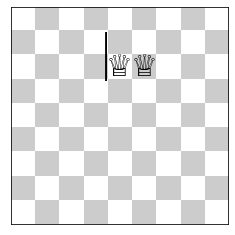

[[[4, 1], [3, 1]], [[3, 1], [4, 1]], [[4, 2], [3, 2]], [[3, 2], [4, 2]], [[2, 1], [4, 1]], [[2, 2], [4, 2]], [[5, 1], [3, 1]], [[5, 2], [3, 2]], [[3, 1], [4, 2]], [[4, 2], [3, 1]], [[3, 2], [4, 1]], [[4, 1], [3, 2]]]


In [109]:
#tests for jumping and wall mechanic

b=board()
b.add_pawn("p1", pawn(5,2))
b.add_pawn("p2", pawn(4,2))
#print(b.pawnController.detect_near("p1"))
#b.add_wall("w1", wall(5, 2, "left"))
b.add_wall("w2", wall(4, 3, "up"))
b.move_pawn("p1", "left")
print(b.pawnController.can_move_to("p2", b.ill_moves("full")))
b.drawBoard()
print(b.ill_moves("wall"))
#print(b.wallController.wallList["w2"].x)

#clase game
#board, player
#player puede acceder a wallList
#board.getWall

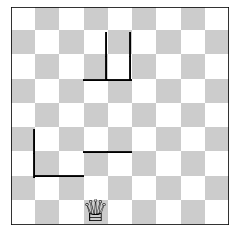

In [110]:
b1=board()
b1.add_pawn("p1", pawn(4,0))
b1.add_wall("w3", wall(5, 6, "left"))
b1.add_wall("w5", wall(4, 3, "up"))
b1.add_wall("w6", wall(3, 7, "left"))
b1.add_wall("w7", wall(1, 7, "up"))
b1.add_wall("w8", wall(5, 3, "left"))
#b1.add_wall("t3", wall(5, 1, "left"))
#b1.add_wall("t4", wall(3, 2, "up"))
#b1.add_wall("t5", wall(5, 2, "up"))
b1.add_wall("F", wall(5, 3, "up"))

def bruteForce(board, target_row, pawn_name):
    while board.get_pawn(pawn_name).y!=8:
        t.sleep(0.2)
        pos_moves=board.pawnController.can_move_to(pawn_name, board.ill_moves("full"))
        if len(pos_moves)==0:
            break
        for i in range(len(pos_moves)):
            if board.get_pawn(pawn_name).future_move(pos_moves[i]) not in board.get_pawn(pawn_name).history:
                board.move_pawn(pawn_name, pos_moves[i])
                break
        board.drawBoard()
bruteForce(b1, 8, "p1")

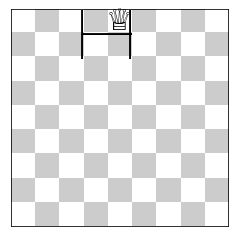

[[[4, 0], [3, 0]], [[3, 0], [4, 0]]]


In [111]:
#tests for pawn.history
b1=board()
b1.add_pawn("p2", pawn(4,0))

b1.add_wall("w3", wall(5, 1, "left"))
b1.add_wall("w4", wall(3, 2, "up"))
b1.add_wall("w5", wall(5, 2, "up"))
print(b1.pawnController.can_move_to("p2", b1.ill_moves("full")))
print([[4, 0], [3, 0]] in b1.ill_moves("full"))
b1.drawBoard()
print(b1.move_pawn("p2", "left"))
b1.drawBoard()
print(b1.move_pawn("p2", "right"))
b1.drawBoard()
print(b1.move_pawn("p2", "left"))
b1.drawBoard()
print(b1.move_pawn("p2", "right"))
b1.drawBoard()
print(b1.move_pawn("p2", "down"))
b1.drawBoard()
print(b1.move_pawn("p2", "up"))
b1.drawBoard()
print(b1.get_pawn("p2").history)

In [112]:
def solveBoard(board, target_row, name, direction):
    

    if board.get_pawn(name).future_move(direction) in  board.ill_moves("full") or board.get_pawn(name).future_move(direction) in board.get_pawn(name).history:
        return False

    board.move_pawn(name, direction)
    board.drawBoard()
    
    if board.get_pawn(name).y == target_row:
        return True
    
    if solveBoard(board, target_row, name, "down"): 
        return True
    if solveBoard(board, target_row, name, "left"): 
        return True
    if solveBoard(board, target_row, name, "right"): 
        return True
    if solveBoard(board, target_row, name, "up"): 
        return True

    return False
    

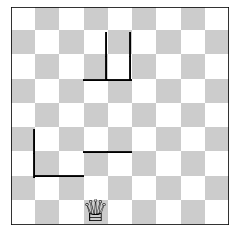

True

In [113]:
b2=board()
b2.add_pawn("Empe", pawn(4,0))

b2.add_wall("w3", wall(5, 6, "left"))
b2.add_wall("w5", wall(4, 3, "up"))
b2.add_wall("w6", wall(3, 7, "left"))
b2.add_wall("w7", wall(1, 7, "up"))
b2.add_wall("w8", wall(5, 3, "left"))
#b2.add_wall("t3", wall(5, 1, "left"))
#b2.add_wall("t4", wall(3, 2, "up"))
#b2.add_wall("t5", wall(5, 2, "up"))
b2.add_wall("F", wall(5, 3, "up"))
solveBoard(b2, 8, "Empe", "down")

In [114]:
def backtrack(board, target_row, pawn_name, direction):   
    if board.get_pawn(pawn_name).future_move(direction) in board.ill_moves("full") or board.get_pawn(pawn_name).future_move(direction) in board.get_pawn(pawn_name).history:
        return False
    
    board.move_pawn(pawn_name, direction)
    board.drawBoard()

    if (board.get_pawn(pawn_name).y == target_row):
        return True

    if backtrack(board, target_row, pawn_name, "down"): return True
    if backtrack(board, target_row, pawn_name, "left"): return True
    if backtrack(board, target_row, pawn_name, "right"): return True
    if backtrack(board, target_row, pawn_name, "up"): return True

    return False

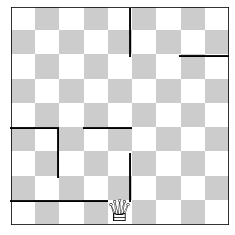

True


In [115]:
b1=board()
b1.add_pawn("p2", pawn(4,0))

b1.add_wall("w5", wall(5, 2, "up"))
b1.add_wall("w6", wall(5, 5, "left"))
b1.add_wall("w7", wall(2, 5, "left"))
b1.add_wall("w12", wall(9, 2, "left"))
b1.add_wall("w8", wall(2, 7, "up"))
b1.add_wall("w9", wall(2, 8, "left"))
b1.add_wall("w10", wall(4, 8, "left"))
b1.add_wall("w11", wall(5, 8, "up"))
print(backtrack(b1, 8, "p2", "down"))

In [116]:
def drawAL(V, G, Vx):
    pos={}
    for i in range(len(nodes)):
        pos[nodes[i]]=(i%9, 9-(i//9))

    gx=nx.Graph()
    nv=len(G)
    gx.add_nodes_from(V)
    for u in range(nv):
        for v in G[u]:
            gx.add_edge(V[u], V[v])
    nx.draw_networkx(gx,
            pos=pos,
            with_labels=True, 
            node_color='orange', 
            alpha=0.8, 
            node_size=750)

In [117]:
def buildBoard():
    nodes=[]
    indexed_nodes={}
    u=0
    for i in range(1, 10):
        for j in range(1, 10):
            nodes.append(chr(96+j)+str(i))
            indexed_nodes[nodes[-1]]=u
            u+=1
    conn=[]
    for i in nodes:
        pos_con=[]
        pos_con.append(chr(ord(i[0]))+str(int(i[1])-1))
        pos_con.append(chr(ord(i[0])+1)+str(int(i[1])))
        pos_con.append(chr(ord(i[0]))+str(int(i[1])+1))
        pos_con.append(chr(ord(i[0])-1)+str(int(i[1])))
        for_delete=[]
        for j in pos_con:
            if 96<ord(j[0])<106 and 0<int(j[1])<10 and len(j)==2:
                pass
            else: for_delete.append(j)
        for j in for_delete:
            pos_con.remove(j)
        to_add=[]
        for j in pos_con:
            to_add.append(indexed_nodes[j])
        conn.append(to_add)
    return nodes, conn, indexed_nodes
    #nodes: los vertices
    #conn: lista de adyacencia
    #indexed_nodes: dict que retorna valor numerico de nodo

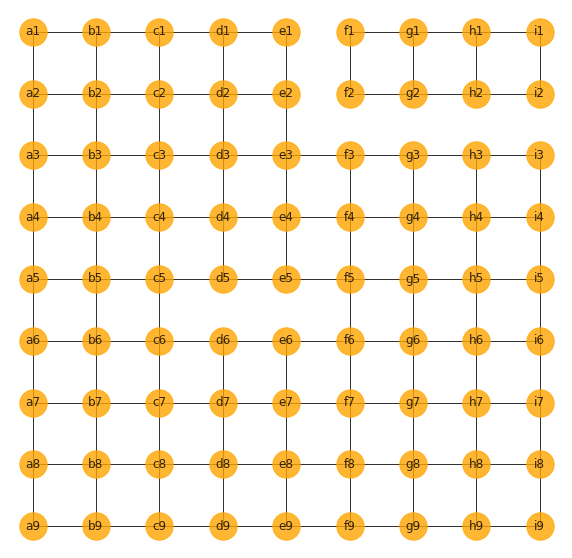

In [118]:
nodes, conn, indexed_nodes=buildBoard()
b3=board()
b3.add_wall("w8", wall(5, 2, "up"))
b3.add_wall("w6", wall(5, 5, "left"))
b3.add_wall("w7", wall(7, 2, "left"))
b3.add_wall("w10", wall(9, 2, "left"))
ill_moves=b3.ill_moves("wall")
conv=[]
for i in ill_moves:
    conv.append([i[0][0]+i[0][1]*9, i[1][0]+i[1][1]*9])
for i in conv:
    if i[1] in conn[i[0]]:
        conn[i[0]].remove(i[1])

plt.figure(1, figsize=(10, 10))
drawAL(nodes, conn, indexed_nodes)
plt.axis('off')
plt.show()

In [142]:
n=len(nodes)
visited=[False]*n
positions=[]
def dfs(u):
    visited[u]=True
    #print(nodes[u])
    positions.append(nodes[u])
    found=False
    for v in conn[u]:
        if nodes[u][1]=='1':
            #print("Found path, ended at: ", nodes[u])
            return True
        if not visited[v] and not found:
            found=dfs(v)
    return found
if dfs(indexed_nodes["d9"]):
    print(positions)

['d9', 'd8', 'd7', 'd6', 'e6', 'f6', 'f5', 'f4', 'f3', 'g3', 'h3', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'h9', 'h8', 'h7', 'h6', 'h5', 'h4', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'f9', 'f8', 'f7', 'e7', 'e8', 'e9', 'e3', 'e2', 'e1']


In [146]:
n=len(nodes)
visited=[False]*n
positions=[]
def bfs(s):
    queue=[]
    queue.append(s)
    visited[s]=True
    while queue :
        u=queue.pop(0)
        positions.append(nodes[u])
        for v in conn[u]:
            if not visited[v]:
                visited[v]=True
                queue.append(v)
        if nodes[u][1]=='1':
            break
bfs(indexed_nodes["d9"])
print(positions)

['d9', 'd8', 'e9', 'c9', 'd7', 'e8', 'c8', 'f9', 'b9', 'd6', 'e7', 'c7', 'f8', 'b8', 'g9', 'a9', 'e6', 'c6', 'f7', 'b7', 'g8', 'a8', 'h9', 'f6', 'c5', 'b6', 'g7', 'a7', 'h8', 'i9', 'f5', 'g6', 'c4', 'd5', 'b5', 'a6', 'h7', 'i8', 'f4', 'g5', 'e5', 'h6', 'c3', 'd4', 'b4', 'a5', 'i7', 'f3', 'g4', 'e4', 'h5', 'i6', 'c2', 'd3', 'b3', 'a4', 'g3', 'e3', 'h4', 'i5', 'c1']


In [150]:
def is_ady(x, y):
    if x[0]==y[0]:
        if int(x[1])+1==int(y[1]) or int(x[1])-1==int(y[1]):
            return True
    elif x[1]==y[1]:
        if ord(x[0])+1==ord(y[0]) or ord(x[0])-1==ord(y[0]):
            return True
    return False

def findPath(positions):
    aux=[]
    positions=positions[::-1] #reverse list
    actual=positions[0]
    cont=0
    aux.append(actual)
    while actual!=positions[-1]:
        cont+=1
        if is_ady(actual, positions[cont]):
            #print(positions[cont])
            aux.append(positions[cont])
            actual=positions[cont]
    aux.pop()
    return aux[::-1]

print(findPath(positions))

['c9', 'c8', 'c7', 'c6', 'c5', 'c4', 'c3', 'c2', 'c1']


In [ ]:
def move_pos(self, pos):
    self.x=97-ord(pos[0])
    self.y=int(pos[1])